In [2]:
from dataloader import *
data = load_data('../annotated', batch_num=[5, 6], preprocess=True)

Loading files: ['../annotated/batch_5_anton.json', '../annotated/batch_5_ayush.json', '../annotated/batch_5_kelly.json', '../annotated/batch_5_rachel.json', '../annotated/batch_5_vinayak.json', '../annotated/batch_5_vishnesh.json', '../annotated/batch_6_anton.json', '../annotated/batch_6_ayush.json', '../annotated/batch_6_kelly.json', '../annotated/batch_6_vinayak.json', '../annotated/batch_6_vishnesh.json']

Found users: {'anton', 'ayush', 'vishnesh', 'rachel', 'vinayak', 'kelly'}

anton - Batch 5, HIT 38 (ID 37) has 2 deletion edits but 1 annotations. Likely a missing annotation. Skipping edit type...
vinayak - Batch 6, HIT 16 (ID 45) has 1 insertion edits but -1 annotations. Likely a missing annotation. Skipping edit type...
rachel - Batch 5, HIT 21 (ID 65) has 4 deletion edits but 3 annotations. Likely a missing annotation. Skipping edit type...
rachel - Batch 5, HIT 21 (ID 65) has 4 insertion edits but 3 annotations. Likely a missing annotation. Skipping edit type...
rachel - Batc

In [3]:
from scoring import *

In [4]:
# Gets parameters for only a certain family of edits
def get_params(op):
    curr_params = default_params.copy()
    params_consider = []
    # Consider only:
    if (op == 'content'):
        # Content edits
        params_consider = [
            'good_deletion',
            'good_insertion',
            'content_error'
        ]
    elif (op == 'syntax'):
        # Syntax edits
        params_consider = [
            'good_syntax'
        ]
    elif (op == 'syntax'):
        # Lexical edits
        params_consider = [
            'good_paraphrase',
            'good_trivial_insertion',
            'grammar_error'
        ]

        # Content quality edits
        # Content error edits
        # Syntax quality edits
        # Syntax error edits
        # Lexical quality edits
        # Lexical error edits

    elif (op == 'quality'):
        # Only quality edits
        params_consider = [
            'good_insertion',
            'good_deletion',
            'good_paraphrase',
            'good_trivial_insertion',
            'good_syntax'
        ]
    elif (op == 'error'):
        # Only error edits
        params_consider = [
            'content_error',
            'grammar_error'
        ]

    params_consider += ['size_calculation']

    for param in curr_params.keys():
        if param not in params_consider:
            curr_params[param] = 0
    
    return curr_params

In [5]:
# Get 5 sentence scores considering only content edits
[x['score'] for x in calculate_sentence_scores(data, get_params('content'))][:5]

[7.773591301605246,
 2.4693095065550312,
 8.485523033480725,
 9.239242635984109,
 9.07563996287343]

In [6]:
# Get sentences where at least 1 annotator identified an error
error = Error.CONTRADICTION
out_sents = set()
for sent in data:
    for ann in sent['processed_annotations']:
        if ann['error_type'] == error:
            out_sents.add((sent['original'], sent['system']))
out = []
for orig in out_sents:
    out.append([x for x in data if x['original'] == orig[0] and x['system'] == orig[1]])

In [ ]:
# Get all sentences where at least 1 annotator identified an error of that type

# Content Errors	
# 	Coreference
# 	Information Rewrite
# 	Repeititon
# 	Contradiction
# 	Hallucination
# 	Irrelevant
# Syntax Errors	
# 	Syntax Error
# Lexical Errors	
# 	Unnecessary Insertion
# 	Complex Wording
# 	Grammar Error

In [9]:
# Calculate the SARI score for all unique sentences
# For each sentence, we have 5 generations and 3 annotations per generation
# Of the 5 generations, 2 are ASSET human references, 1 is TurkCorpus human reference

scores = []
for orig in set([x['original'] for x in data]):
    sents = [x for x in data if x['original'] == orig]

    asset = [x for x in sents if 'asset' in x['system']]
    t5 = [x for x in sents if 'T5' in x['system']][0]

    # Take the SARI score for T5, our best generation with the 2 ASSET human references
    references = [x['simplified'] for x in asset]
    prediction = t5['simplified']
    
    simpeval_score = t5['simpeval_score']
    our_score = t5['score']

    # The next goal is to calculate a bunch of variations on our score considering only
    # certain dimensions of the metric

    # Then we can calculate more complex automatic metrics like BERTScore, COMET

    sari_score = sari.compute(sources=[orig], predictions=[prediction], references=[references])['sari']

    scores.append({
        'original': orig,
        'simplified': prediction,
        'sari': sari_score,
        'simpeval': simpeval_score,
        'our_score': our_score
    })

# Small sample size
scores[0]

IndexError: list index out of range

In [27]:
# The problem with BERTScore is my verion of PyTorch is
# incompatible with their library, I'll have to use a virtual
# environment to get it to work.

# from bert_score import score

# with open("bert_score/example/hyps.txt") as f:
#     cands = [line.strip() for line in f]

# with open("bert_score/example/refs.txt") as f:
#     refs = [line.strip() for line in f]

# P, R, F1 = score(cands, refs, lang="en", verbose=True)

# print(f"System level F1 score: {F1.mean():.3f}")

In [28]:
# import comet
# They have a python library but it doesn't work great...

# !echo -e "Dem Feuer konnte Einhalt geboten werden\nSchulen und Kindergärten wurden eröffnet." >> comet/src.de
# !echo -e "The fire could be stopped\nSchools and kindergartens were open" >> comet/hyp1.en
# !echo -e "The fire could have been stopped\nSchools and pre-school were open" >> comet/hyp2.en
# !echo -e "They were able to control the fire.\nSchools and kindergartens opened" >> comet/ref.en

# !comet-score -s comet/src.de -t comet/hyp1.en -r comet/ref.en

In [29]:
# One of the COMET scores worth looking at:
# wmt21-comet-mqm: This model was pre-trained on Direct Assessments from WMT15 to WMT20 and then fine-tuned on MQM z-scores from Freitag et al, 2021 (MQM). This model was one of the best performing metrics that year [Freitag et al. 2021 (WMT21)].

### Edit Reversing

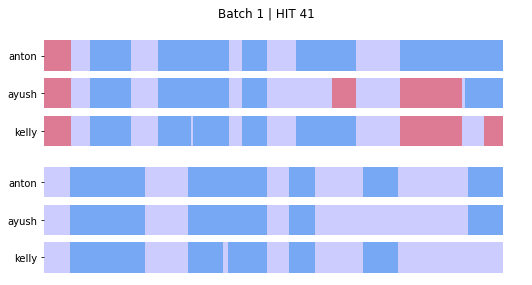

In [ ]:
from graphs import *

id_ = 40
sents = [sent for sent in data if sent['id'] == id_]
draw_agreement(sents)

In [ ]:
# Problems with reversing edits:
    # Overlapping edits (of different types)
    # Deletions have no mapping to the original sentence
    # Re-orders have no mapping to their original location

In [ ]:
# My approach
    # use generate_token_dict(s) to get a list of token spans for the input/output
    # iterate through edits (in some predetermined priority order) to list the operations we perform on each word
    # perform those operations to collapse the sentence

In [ ]:
s = sents[0]
orig = s['original']
simp = s['simplified']

In [ ]:
generate_token_dict(orig)

{(0, 2): {},
 (3, 10): {},
 (11, 16): {},
 (17, 22): {},
 (23, 29): {},
 (30, 32): {},
 (33, 41): {},
 (42, 51): {},
 (52, 54): {},
 (55, 68): {},
 (69, 72): {},
 (73, 82): {},
 (83, 85): {},
 (86, 92): {},
 (93, 96): {},
 (97, 105): {},
 (106, 112): {},
 (113, 115): {},
 (116, 122): {},
 (123, 130): {},
 (131, 134): {},
 (135, 145): {},
 (146, 148): {},
 (149, 154): {},
 (155, 161): {},
 (162, 169): {}}

In [ ]:
s['edits'][0]

{'type': 'deletion',
 'id': 0,
 'original_span': [(0, 10)],
 'simplified_span': None,
 'annotation': ['good', 'no', 'no']}

In [ ]:
s['edits'][1]['original_span'][0]

(17, 32)

In [ ]:
s['edits'][1]['simplified_span'][0]

(6, 23)

In [ ]:
out[17:32]

'swore fealty to'

In [ ]:
s['simplified'][6:23]

'promised to serve'

In [ ]:
out

'In return, Rollo swore fealty to Charles, converted to Christianity, and undertook to defend the northern region of France against the incursions of other Viking groups.'

In [ ]:
# Reversing only substitutions
sents[0]['edits']

[{'type': 'deletion',
  'id': 0,
  'original_span': [(0, 10)],
  'simplified_span': None,
  'annotation': ['good', 'no', 'no']},
 {'type': 'substitution',
  'id': 0,
  'original_span': [(17, 32)],
  'simplified_span': [(6, 23)],
  'annotation': ['same', 'positive', 'a lot', '', 'no']},
 {'type': 'substitution',
  'id': 1,
  'original_span': [(42, 68)],
  'simplified_span': [(33, 51)],
  'annotation': ['same', 'positive', 'somewhat', '', 'no']},
 {'type': 'substitution',
  'id': 2,
  'original_span': [(73, 82)],
  'simplified_span': [(56, 62)],
  'annotation': ['less', 'good', 'no', '']},
 {'type': 'substitution',
  'id': 3,
  'original_span': [(93, 115)],
  'simplified_span': [(73, 81)],
  'annotation': ['less', 'perfect', 'no', '']},
 {'type': 'substitution',
  'id': 4,
  'original_span': [(131, 169)],
  'simplified_span': [(97, 105)],
  'annotation': ['less', 'good', 'no', '']}]